# ERA5 Near-surface Temperature Anomaly

## Quality question: 

* ### How well does ERA5 reanalysis near-surface temperature variabilty?
<br>

* ### Dose  ERA5 homogenous dataset without significant artificial discontinuities?
<br>

ERA5 reanalysis provides a global coverage (gap-free) of more than 80 years of complete and continuous records of temperature at 2 meters. This enables conducting research about climate variability in the long term. 

The next analysis addresses how reliable ERA5 represents the variability pattern of the near-surface temperature and if the dataset has a homogenous record or has artificial discontinuities over the long-term record.
 

## The analysis comprises the following steps:

1. Download the ERA5 monthly temperature at 2-meter (t2m) for the period 1940 - 2022
2. Calculate the t2m climatology at different periods
3. Calculate the t2m anomaly time series at both global and regional scales
4. Analyze results

### _General Setup: import libraries and credentials for CDSAPI_

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from c3s_eqc_automatic_quality_control import download, plot, utils, diagnostics
import pandas as pd
import matplotlib.dates as mdates
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/.cdsapirc")

### _Setting up data the request_
_First, we need to set up the request to be send to the CADS - here follows the one for the catalogue entry "ERA5 monthly data on single levels from 1940 to present"_

In [2]:
collection_id = "reanalysis-era5-single-levels-monthly-means"
request = {
    'product_type': 'monthly_averaged_reanalysis',
    'variable': '2m_temperature',
    'time': '00:00',
    'format': 'grib',
}
start, stop = "1940-01", "2022-12" 
requests = download.update_request_date(request, start=start, stop=stop, stringify_dates=True)

### _Download the dataset_

In [3]:
ds = download.download_and_transform(
    collection_id,
    requests,
    chunks={"year": 1, "month": 1},
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996 [00:07<00:00, 141.04it/s]


### To calculate anomaly,  we need to subtract the monthly climatology from the dataset's monthly time series. 
According to WMO, climatology standards are calculated for a uniform 30-year period. 
The definition of the standard period changed over time. Currently, it is defined as the most recent 30-year period finishing in a year ending with 0 (e.g., 1981–2010, 1991–2020, etc.) rather than to non-overlapping 30-year periods (1931–1960, 1961–1990, etc.).
<br>

We use three different climatological periods here and investigate the temperature anomaly according to them.

#### 1. The most recent 30-year period: 1991 - 2020 
#### 2. The 30-year preceding the latest climatological period: 1981 - 2010
#### 3. The old standard period: 1961 - 1990
<br>

This allows us to explore the impact of the chosen period in temperature anomaly value in the long time series. 

In [4]:
ds_global=diagnostics.spatial_weighted_mean(ds)   #Global mean for the full temporal coverage of the dataset

ds_period_1 = ds.sel(forecast_reference_time=slice('1991-01-01', '2020-12-01'))
clim_mon_p1_global=diagnostics.spatial_weighted_mean(ds_period_1)
clim_mon_p1=clim_mon_p1_global.groupby('time.month').mean() # monthly mean climatology for period 1

ds_period_2 = ds.sel(forecast_reference_time=slice('1981-01-01', '2010-12-01'))
clim_mon_p2_global=diagnostics.spatial_weighted_mean(ds_period_2)
clim_mon_p2=clim_mon_p2_global.groupby('time.month').mean() # monthly mean climatology for period 2

ds_period_3 = ds.sel(forecast_reference_time=slice('1961-01-01', '1990-12-01'))
clim_mon_p3_global=diagnostics.spatial_weighted_mean(ds_period_3)
clim_mon_p3=clim_mon_p3_global.groupby('time.month').mean() # monthly mean climatology for period 3

### Calculate Anomaly relative to the three addressed period

In [5]:
anom_p1= ds_global.groupby('time.month') - clim_mon_p1  #t2m Anomaly relative to period 1 climatology
anom_p2= ds_global.groupby('time.month') - clim_mon_p2  
anom_p3= ds_global.groupby('time.month') - clim_mon_p3  

## Visualize results

### 1- Global mean monthly climatological temperature

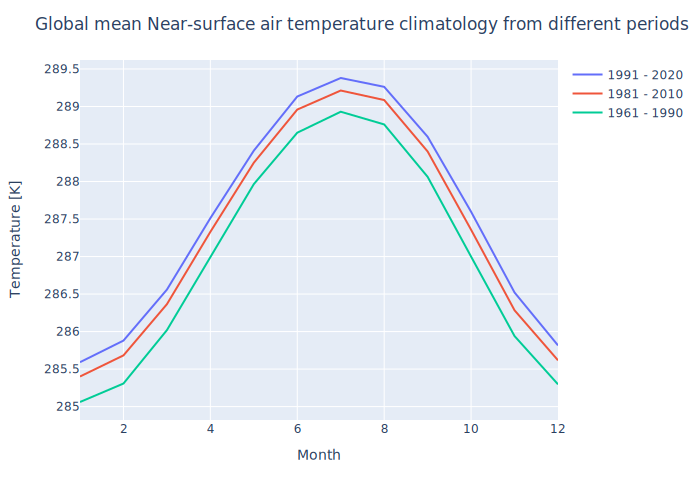

In [6]:
fig =px.scatter(x=clim_mon_p1.month, y=clim_mon_p1.t2m)
fig.update_traces(name='1991 - 2020', mode='lines', showlegend=True)

fig.add_scatter(x=clim_mon_p2.month,y=clim_mon_p2.t2m, mode='lines',name='1981 - 2010', showlegend=True)
fig.add_scatter(x=clim_mon_p3.month,y=clim_mon_p3.t2m, mode='lines',name='1961 - 1990', showlegend=True)

fig.update_layout(
  title="Global mean Near-surface air temperature climatology from different periods",
  xaxis_title="Month",
  yaxis_title="Temperature [K]"
)
fig.show(renderer='svg')

The result shows about 0.2 deg. year around in the most recent period higher than the preceding period, while the old period was about 0.6° colder than it

## Global temperature anomaly time series

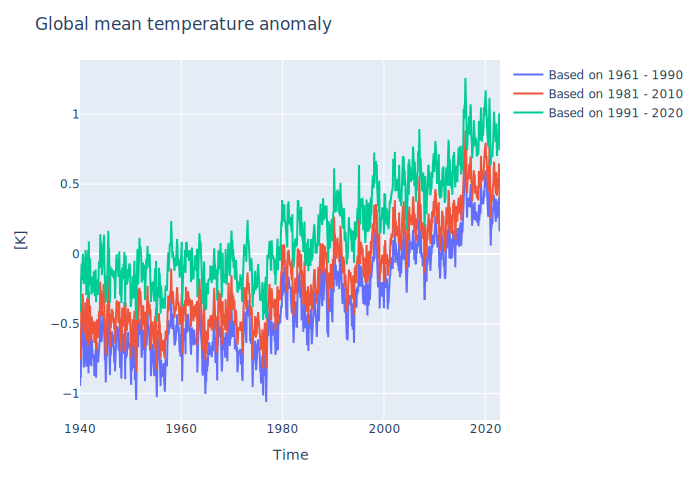

In [7]:
fig=px.scatter(x=anom_p1.time,y=anom_p1.t2m)
fig.update_traces(
    name='Based on 1961 - 1990',
    mode='lines',
    showlegend=True)
    
fig.add_scatter(x=anom_p2.time,y=anom_p2.t2m, mode='lines',name='Based on 1981 - 2010',showlegend=True)
fig.add_scatter(x=anom_p3.time,y=anom_p3.t2m, mode='lines',name='Based on 1991 - 2020',showlegend=True)



fig.update_layout(
  title="Global mean temperature anomaly",
  xaxis_title="Time",
  yaxis_title="[K]"

)

fig.show(renderer='svg')

The results shows a rapid warming in the past few decades for the global temperature. Further, the warming associated with the strongest El-Niño events is well represented for winter 1957/58, 1972/82, 1982/83, 1997/98, 2016/17), but not in 1965/66.  
<br>

The figure depicts an artifact discontinuity in the data near 1980, but also 1958. This is likely could be related to increasing the amount of the assimilated observation in the dataset after 1980, and/or merging the back-extension with the opertional streams of ERA5 production.
<br>

To better undertand the obtaind results, in the next analysis we investigate the timeseries on a regional scale and assess if the results refelect the same finding or the global average driven by spcific region.


### Regional temperature anomaly time series 

#####    a. Tropical and mid-latitude regions

In [8]:
#Tropics
ds_TR=ds.where((ds.latitude >= -30) & (ds.latitude <= 30), drop=True) 
mean_TR=diagnostics.spatial_weighted_mean(ds_TR)
clim_mean_TR=mean_TR.sel(forecast_reference_time=slice('1991-01-01', '2020-12-01')).groupby('time.month').mean() 
anom_TR= mean_TR.groupby('time.month') - clim_mean_TR

# northern mid latitude

ds_Nmid=ds.where((ds.latitude >= 30) & (ds.latitude <= 60), drop=True) 
mean_Nmid=diagnostics.spatial_weighted_mean(ds_Nmid)
clim_mean_Nmid=mean_Nmid.sel(forecast_reference_time=slice('1991-01-01', '2020-12-01')).groupby('time.month').mean()
anom_Nmid= mean_Nmid.groupby('time.month') - clim_mean_Nmid

# southern mid latitude

ds_Smid=ds.where((ds.latitude >= -60) & (ds.latitude <= -30), drop=True) 
mean_Smid=diagnostics.spatial_weighted_mean(ds_Smid)
clim_mean_Smid=mean_Smid.sel(forecast_reference_time=slice('1991-01-01', '2020-12-01')).groupby('time.month').mean() 
anom_Smid= mean_Smid.groupby('time.month') - clim_mean_Smid

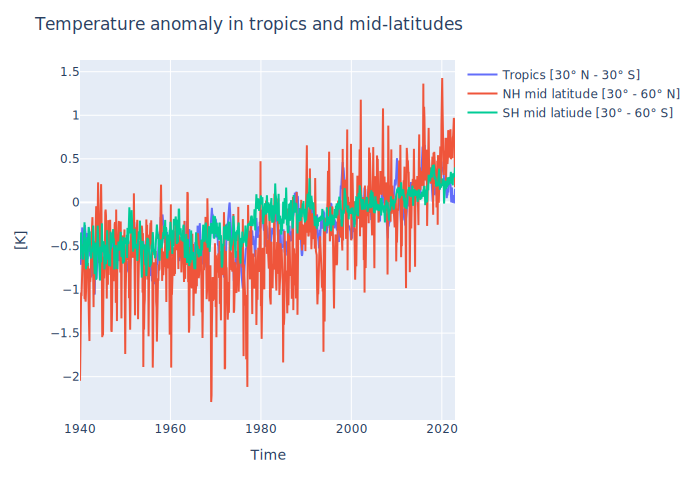

In [9]:
fig_4=px.scatter(x=anom_TR.time,y=anom_TR.t2m)
fig_4.update_traces(
    name='Tropics [30° N - 30° S]',
    mode='lines',
    showlegend=True)


fig_4.add_scatter(x=anom_Nmid.time,y=anom_Nmid.t2m, mode='lines',name='NH mid latitude [30° - 60° N]',showlegend=True)

fig_4.add_scatter(x=anom_Smid.time,y=anom_Smid.t2m, mode='lines',name='SH mid latiude [30° - 60° S]',showlegend=True)


fig_4.update_layout(
  title="Temperature anomaly in tropics and mid-latitudes",
  xaxis_title="Time",
  yaxis_title="[K]"

)
fig_4.show(renderer='svg')

#####    b. Polar regions

In [10]:
ds_NP=ds.where(ds.latitude > 60,drop=True) #northern pole
ds_SP=ds.where(ds.latitude < -60,drop=True) #southern pole

mean_NP=diagnostics.spatial_weighted_mean(ds_NP)
clim_mean_NP=mean_NP.sel(forecast_reference_time=slice('1991-01-01', '2020-12-01')).groupby('time.month').mean() # monthly mean
anom_NP= mean_NP.groupby('time.month') - clim_mean_NP

mean_SP=diagnostics.spatial_weighted_mean(ds_SP)
clim_mean_SP=mean_SP.sel(forecast_reference_time=slice('1991-01-01', '2020-12-01')).groupby('time.month').mean() # monthly mean
anom_SP= mean_SP.groupby('time.month') - clim_mean_SP


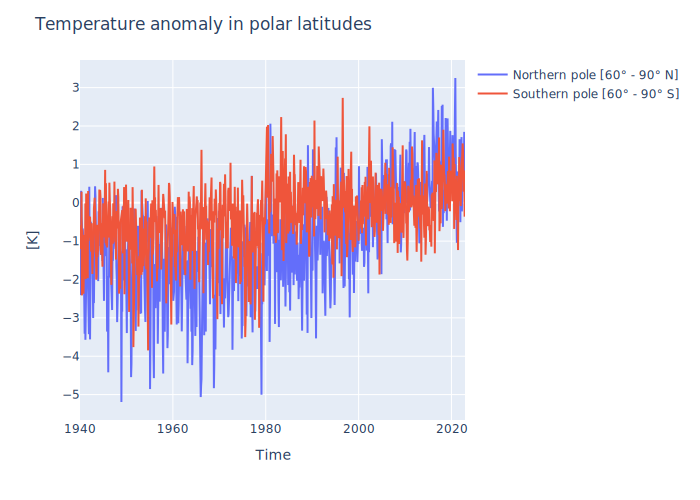

In [11]:
fig_2=px.scatter(x=anom_NP.time,y=anom_NP.t2m)
fig_2.update_traces(
    name='Northern pole [60° - 90° N]',
    mode='lines',
    showlegend=True)

fig_2.add_scatter(x=anom_SP.time,y=anom_SP.t2m, mode='lines',name='Southern pole [60° - 90° S]',showlegend=True)

fig_2.update_layout(
  title="Temperature anomaly in polar latitudes",
  xaxis_title="Time",
  yaxis_title="[K]"

)
fig_2.show(renderer='svg')

The figure indicates that the largest variability is associated with the northern hemisphere mid-to-high latitudes and southern polar regions, with the lowest variability in the tropics and southern hemisphere mid-latitudes. This matches expectations on a physical basis and direct in-situ observations as well. 

## Main outcome

* Tendency to global warming is not evident before 1940 - 1980; thereafter, the temperature increased rapidly in the dataset.

* Warming associated with the strongest El-Niño events is well represented for winter 1957/58, 1972/82, 1982/83, 1997/98, 2016/17), but not in 1965/66.

* Artifact discontinuity in the data is evident near 1980 and 1958 on both global and regional scales

* Largest temperature variability observed in the Northern Hemisphere
 
* Tropics and Southern Hemisphere mid-latitude characterized by lowest temperature variability

## Reference/Useful material

* WMO Climate Normals: https://www.ncei.noaa.gov/products/wmo-climate-normals#:~:text=The%20Global%20Climatological%20Standard%20Normals,precipitation%2C%20and%20other%20climatological%20variables. 

* ERA5 1979 - present: Hersbach, H. et al .(2020). The ERA5 global reanalysis. Q J R Meteorol Soc. 2020; 146: 1999– 2049. https://doi.org/10.1002/qj.3803

* ERA5 back-extension: Bell, B. et al. (2021) The ERA5 global reanalysis: Preliminary extension to 1950. Q J R Meteorol Soc, 147( 741, 4186– 4227. Available from: https://doi.org/10.1002/qj.4174